In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import csv
import rasterio
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import Conv2d as Conv2D
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Upsample
import random
from torch.utils.data import Dataset
import tifffile
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable


In [74]:
import model as new
import unet2 as unet2
import unet3 as unet3
import unetplus as unetplus 

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
mod="Final/checkpoint/443_0.7407724857330322.pth"
mod1="Final/checkpoint/323_0.7225825190544128.pth"
modunet2="Final/unet2/201_0.5986243486404419.pth"
modunet3="Final/unet3/188_0.5832989811897278.pth"
modunetplus2="Final/unet++2/194_0.6209248304367065.pth"
modunetplus3="Final/unet++3/195_0.5971041321754456.pth"


In [3]:
root_dir="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Data/"
test_path=root_dir+"txt/test.txt"
with open(test_path, "r") as test:
    lines_test =test.readlines()
    list_test=[i[:-1] for i in lines_test]

In [9]:
root_dir="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Data/"
bolivia_path=root_dir+"txt/bolivia.txt"
with open(bolivia_path, "r") as bolivia:
    lines_bolivia =bolivia.readlines()
    list_bolivia=[i[:-1] for i in lines_bolivia]

In [398]:
path="/home/yylab/Research/Flood/Sen1Floods11_all/Project/"
name=list_test[10]
pic=path+"Data/S1/"+name+"_S1Hand.tif"
mas=path+"Data/Label/"+name+"_LabelHand.tif"
dem=path+"Data/DEM/"+name+"_DEM.tif"

In [399]:
###展示Label标签###

In [400]:
Label_data=np.uint8(rasterio.open(mas).read())
location = np.argwhere(Label_data==255).tolist()
Label_data[Label_data==255]=0

(-0.5, 511.5, 511.5, -0.5)

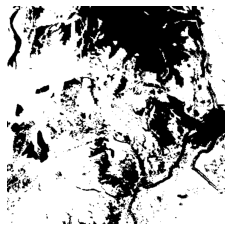

In [401]:
plt.imshow(Label_data[0],cmap='gray')
plt.axis("off")

In [402]:
###展示 融合的 结果###

In [403]:
S1_data=np.nan_to_num(tifffile.imread(pic))
arr_x = np.clip(S1_data, -50, 1)
arr_x = (arr_x + 50) / 51
S1_0_NORM = arr_x[0]
S1_1_NORM = arr_x[1]
DEM_data=tifffile.imread(dem)

(-0.5, 511.5, 511.5, -0.5)

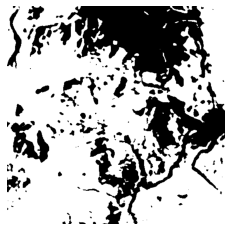

In [404]:
NET=new.UNet()
checkpoint = torch.load(path+mod1)
NET.load_state_dict(checkpoint)
S10NORM = np.expand_dims(S1_0_NORM, axis=0)
S11NORM = np.expand_dims(S1_1_NORM, axis=0)
S0_NORM = torch.from_numpy(S10NORM).type(torch.FloatTensor)
S1_NORM = torch.from_numpy(S11NORM).type(torch.FloatTensor)
DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
DEM = torch.from_numpy(DEM_NORM).type(torch.FloatTensor)
SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=1)
inputs=SUM.unsqueeze(0)
NET = NET.eval()
NET = NET.to(device)
out = NET(inputs.to(device))
a= torch.argmax(out, dim=1).cpu().numpy()
for l in location:
    a[l[0],l[1],l[2]]=0
plt.imshow(a[0],cmap='gray')
plt.axis("off")

In [405]:
###展示 unet3 结果###fcn

(-0.5, 511.5, 511.5, -0.5)

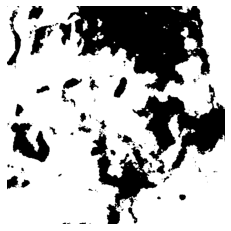

In [406]:
NET=unet3.unet3(3,3)
checkpoint = torch.load(path+modunet3)
NET.load_state_dict(checkpoint)
S10NORM = np.expand_dims(S1_0_NORM, axis=0)
S11NORM = np.expand_dims(S1_1_NORM, axis=0)
S0_NORM = torch.from_numpy(S10NORM).type(torch.FloatTensor)
S1_NORM = torch.from_numpy(S11NORM).type(torch.FloatTensor)
DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
DEM = torch.from_numpy(DEM_NORM).type(torch.FloatTensor)
SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=0)
inputs=SUM.unsqueeze(0)
NET = NET.eval()
NET = NET.to(device)
out = NET(inputs.to(device))
a= torch.argmax(out, dim=1).cpu().numpy()
for l in location:
    a[l[0],l[1],l[2]]=0
plt.imshow(a[0],cmap='gray')
plt.axis("off")

In [407]:
###展示 unet2 结果###unet

(-0.5, 511.5, 511.5, -0.5)

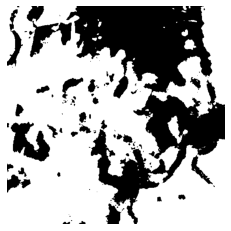

In [408]:
NET=unet2.unet2(2,3)
checkpoint = torch.load(path+modunet2)
NET.load_state_dict(checkpoint)
S10NORM = np.expand_dims(S1_0_NORM, axis=0)
S11NORM = np.expand_dims(S1_1_NORM, axis=0)
S0_NORM = torch.from_numpy(S10NORM).type(torch.FloatTensor)
S1_NORM = torch.from_numpy(S11NORM).type(torch.FloatTensor)
SUM = torch.cat((S0_NORM,S1_NORM),dim=0)
norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
SUM = norm(SUM)
inputs=SUM.unsqueeze(0)
NET = NET.eval()
NET = NET.to(device)
out = NET(inputs.to(device))
a= torch.argmax(out, dim=1).cpu().numpy()
for l in location:
    a[l[0],l[1],l[2]]=0
plt.imshow(a[0],cmap='gray')
plt.axis("off")

In [409]:
###展示 unet++3 结果###deeplab

(-0.5, 511.5, 511.5, -0.5)

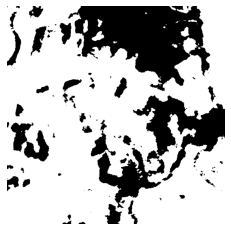

In [410]:
NET=unetplus.unetplus(3,3)
checkpoint = torch.load(path+modunetplus3)
NET.load_state_dict(checkpoint)
S10NORM = np.expand_dims(S1_0_NORM, axis=0)
S11NORM = np.expand_dims(S1_1_NORM, axis=0)
S0_NORM = torch.from_numpy(S10NORM).type(torch.FloatTensor)
S1_NORM = torch.from_numpy(S11NORM).type(torch.FloatTensor)
DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
DEM = torch.from_numpy(DEM_NORM).type(torch.FloatTensor)

norm1 = transforms.Normalize([0.6851], [0.0820])    
norm2 = transforms.Normalize([0.5235], [0.1102])    
S0_NORM = norm1(S0_NORM)
S1_NORM = norm1(S1_NORM)

SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=0)   

inputs=SUM.unsqueeze(0)
NET = NET.eval()
NET = NET.to(device)
out = NET(inputs.to(device))
a= torch.argmax(out, dim=1).cpu().numpy()
for l in location:
    a[l[0],l[1],l[2]]=0
plt.imshow(a[0],cmap='gray')
plt.axis("off")

In [411]:
###展示 unet++2 结果###u2net

(-0.5, 511.5, 511.5, -0.5)

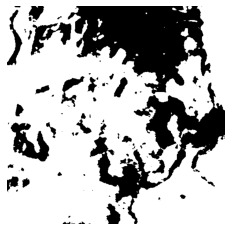

In [412]:
NET=unetplus.unetplus(2,3)
checkpoint = torch.load(path+modunetplus2)
NET.load_state_dict(checkpoint)
S10NORM = np.expand_dims(S1_0_NORM, axis=0)
S11NORM = np.expand_dims(S1_1_NORM, axis=0)
S0_NORM = torch.from_numpy(S10NORM).type(torch.FloatTensor)
S1_NORM = torch.from_numpy(S11NORM).type(torch.FloatTensor)
SUM = torch.cat((S0_NORM,S1_NORM),dim=0)
norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
SUM = norm(SUM)
inputs=SUM.unsqueeze(0)
NET = NET.eval()
NET = NET.to(device)
out = NET(inputs.to(device))
a= torch.argmax(out, dim=1).cpu().numpy()
for l in location:
    a[l[0],l[1],l[2]]=0
plt.imshow(a[0],cmap='gray')
plt.axis("off")

In [413]:
Label_data=np.uint8(rasterio.open(mas).read())

In [389]:

location = np.argwhere(Label_data==255).tolist()

In [116]:
location

4905

In [112]:
a.shape

(1, 512, 512)

In [113]:
a[0,0,0]

1

In [117]:
for l in location:
    a[l[0],l[1],l[2]]=0